In [1]:
#Check the current working directory
import os
print(os.getcwd())

/DATA05/home/jiwoolim24/test


In [2]:
#scanpy tutorial day 1

#load required libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors #pip install scikit-learn
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl #pip install kneed

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')


In [4]:
#set up directory
large_root = "/DATA05/home/jiwoolim24/test/scRNAseq_Workshop"
results_file = large_root + "\pbmc3k.h5ad"

In [5]:
#load data
print("Reading data...")
adata = sc.read_10x_mtx(large_root, var_names = 'gene_symbols',
                        cache=True)

Reading data...
... reading from cache file cache/DATA05-home-jiwoolim24-test-scRNAseq_Workshop-matrix.h5ad


In [6]:
#print data
adata
# obs = cells  vars = genes
#2700 cells and 32738 genes. Data are 3000 peripheral blood mononuclear cells (immune cell types)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


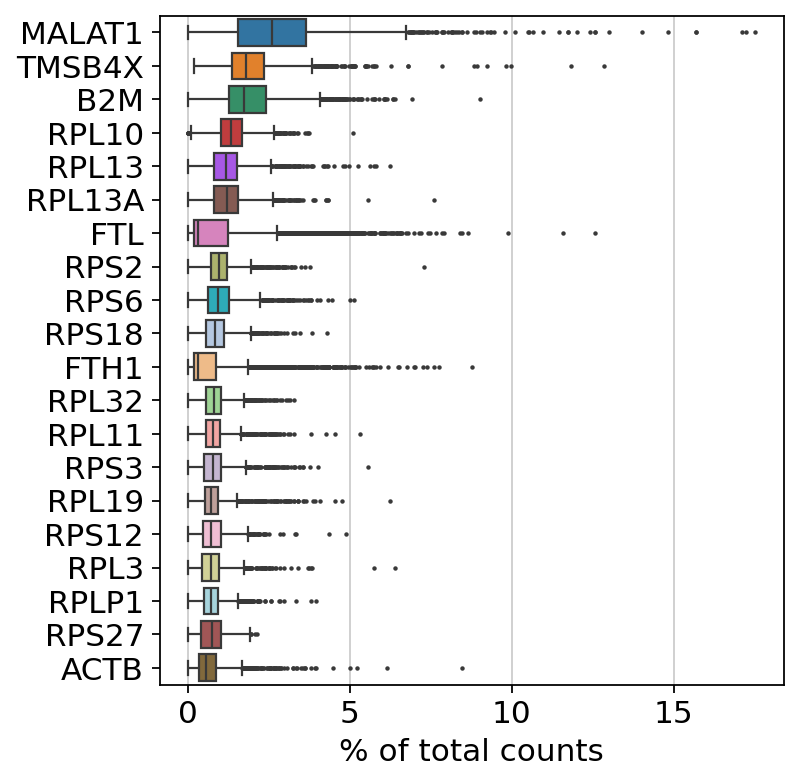

In [7]:
#show genes that yield highest fraction of counts
sc.pl.highest_expr_genes(adata, n_top=20, )


In [8]:
# annotate mitochondrial genes as 'mt' and calculate qc metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

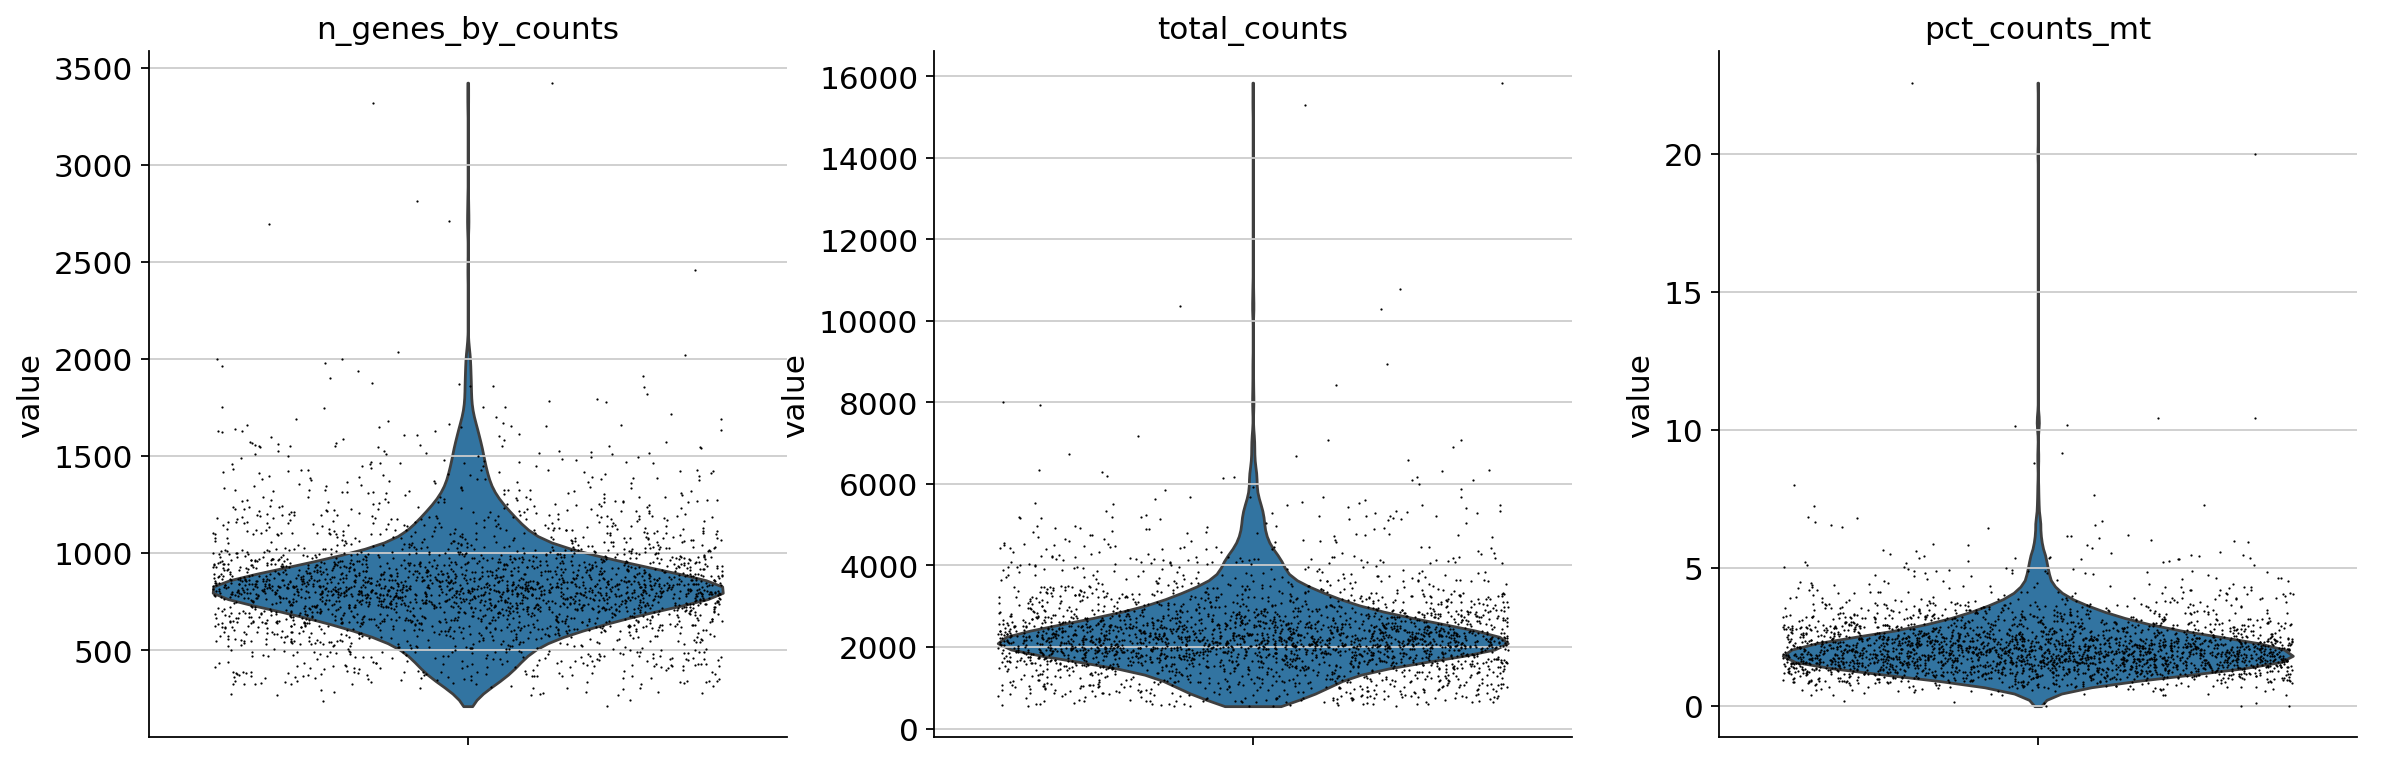

In [9]:
# plot a violin plot with some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
# n_genes_by_counts show low number of genes for each cell. total_counts show low number of total counts. 
# Most of cells have 2% of mt genes, and some outlieres around 15-20% of total cells.

/tmp/ipykernel_4076926/1087000666.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["n_genes_by_counts"])


<Axes: xlabel='n_genes_by_counts', ylabel='Density'>

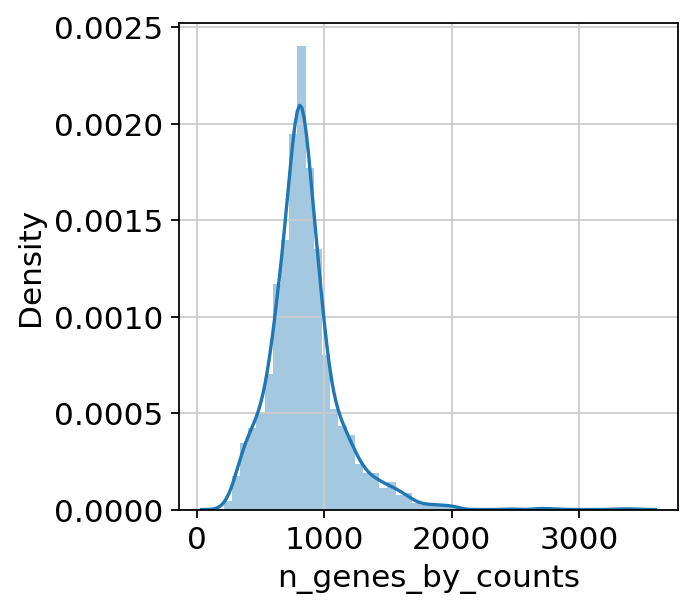

In [10]:
# plot a histograph of a single variable
# seaborn graph
sns.distplot(adata.obs["n_genes_by_counts"])


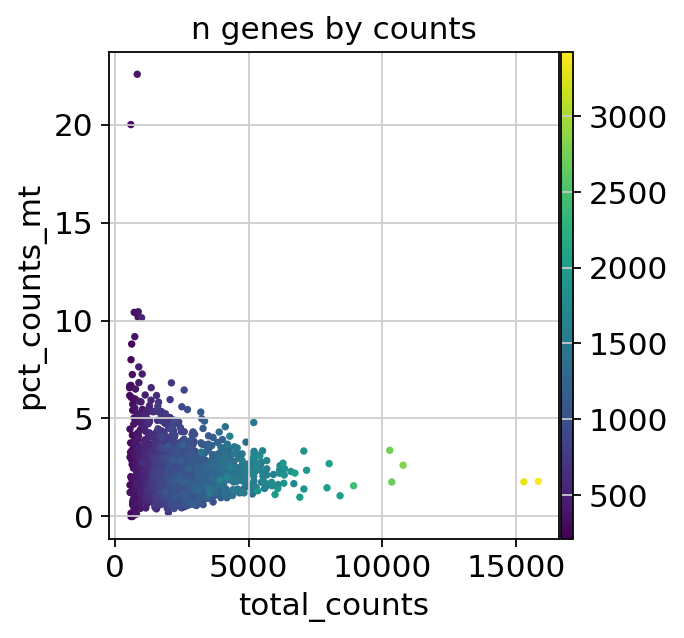

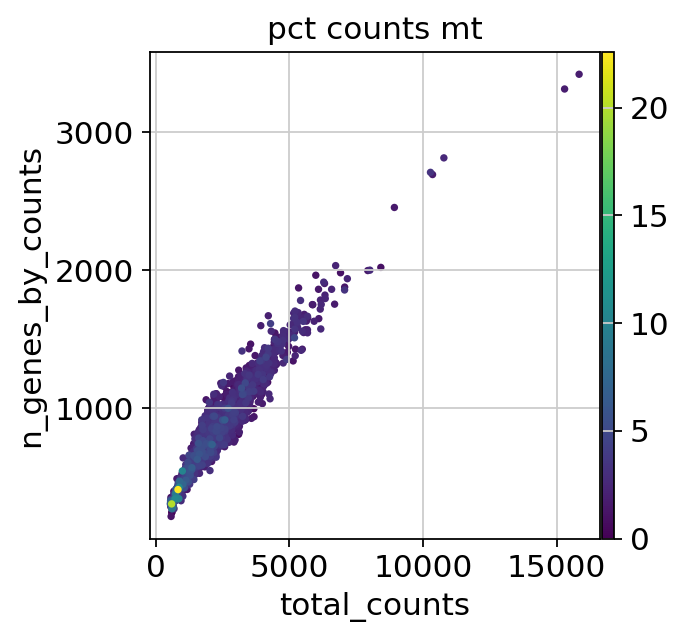

In [11]:
# plot a scatter plot of QC metrics
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = 'n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt')
#1st graph: Trim off tail of the distribution in which cells that have the highest fraction of mitochondria also fall within the lowest spin of total counts (unhappy cells). 
#2nd graph: Trim off doublets

In [12]:
#basic filtering
#removing very sparse genes to avoid introducing very high variants later on (additional safeguard)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
#scanpy tutorial put min_genes=100

# actually do the filtering by slicing the AnnData object
# we created a new adata 'bdata' so that we can go back and compare our annotated 'unfiltered' to our 'filtered bdata'
bdata = adata
bdata = bdata[bdata.obs.n_genes_by_counts < 2200, :] #2nd graph: Trim off doublets 
bdata = bdata[bdata.obs.pct_counts_mt < 5, :] #1st graph: Trim off tail of the distribution in which cells that have the highest fraction of mitochondria also fall within the lowest spin of total counts (unhappy cells). 
# include those cells whose fraction of mitochondrial counts are <5. retaining the resulting entries in our matrices

filtered out 19024 genes that are detected in less than 3 cells


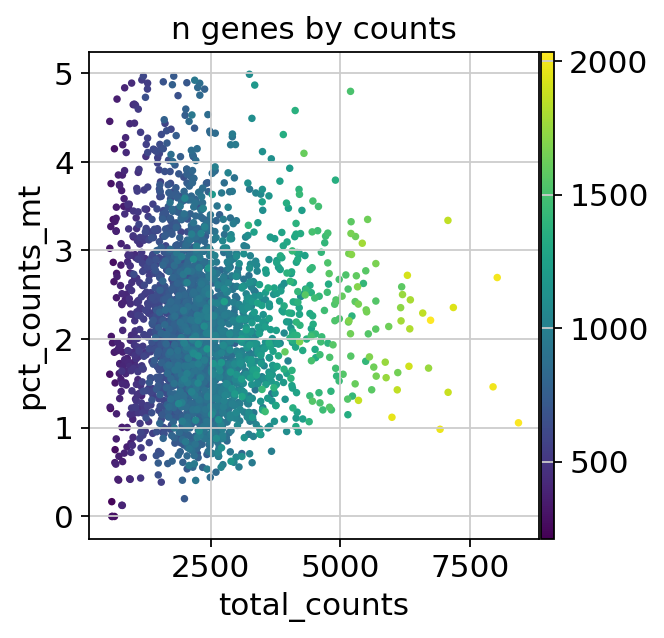

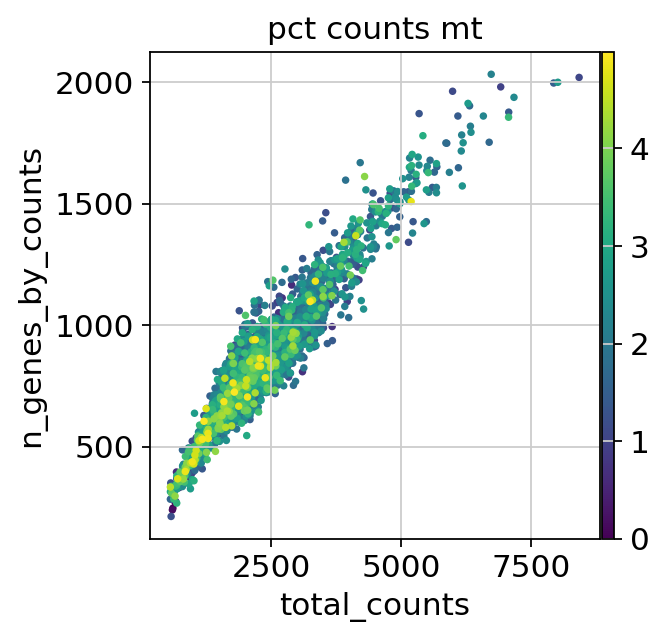

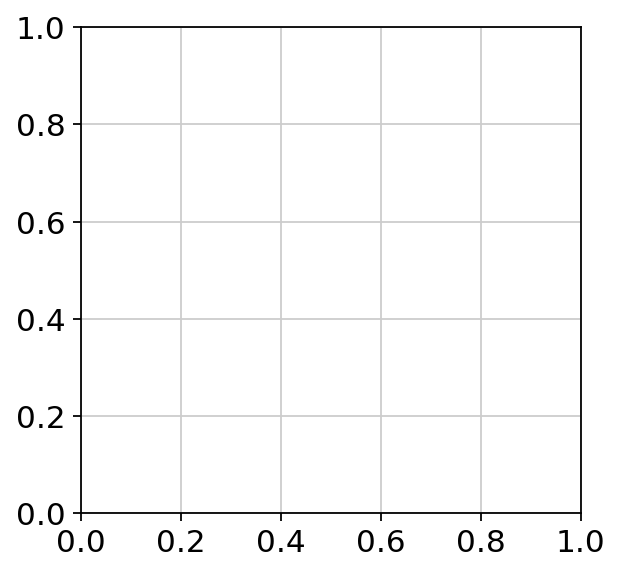

In [13]:
# plot a scatter plot of filtered data
sc.pl.scatter(bdata, x='total_counts', y='pct_counts_mt', color = 'n_genes_by_counts')
sc.pl.scatter(bdata, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt')

# save plot
ax = plt.gca()
plt.savefig(large_root + "/" + " QCafter.png")
